In [28]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import mne
from mne.decoding import cross_val_multiscore
from mne import Epochs, create_info, events_from_annotations
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import AverageTFR

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from typing import Union
from utils.beep import Beeper
from sklearn.base import BaseEstimator
from abc import ABC, abstractmethod
from typing import Optional, Iterable, Generator, Callable
from mne import EpochsArray
from collections import UserDict, UserList
from combiners import EpochsCombiner
from mne.decoding import SlidingEstimator

# speakers
# sad_beep = Beeper(duration=[.1, .15, .25], frequency=[280, 240, 190], repeat=3)
# happy_beep = Beeper(duration=[.1, .1, .15, .25], frequency=[400, 370, 470, 500], repeat=4)

# paths
content_root = '../'
subjects_folder_path = os.path.join(content_root, 'Source/Subjects')
subject_path = os.path.join(subjects_folder_path, 'Az_Mar_05')
raw_file_path = os.path.join(subject_path, 'Raw', 'ML_Subject05_P1_tsss_mc_trans.fif')
raw_path = os.path.join(subject_path, 'Raw', 'ML_Subject05_P1_tsss_mc_trans.fif')
resp_lock_lm_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'resp_lock_lm_B1_epochs.fif')
resp_lock_rm_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'resp_lock_rm_B1_epochs.fif')
resp_lock_li_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'resp_lock_li_B1_epochs.fif')
resp_lock_ri_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'resp_lock_ri_B1_epochs.fif')

# readers
original_data = mne.io.read_raw_fif(raw_file_path)
original_info = original_data.info
resp_lock_lm_B1_epochs = mne.read_epochs(resp_lock_lm_B1_epochs_path)
resp_lock_rm_B1_epochs = mne.read_epochs(resp_lock_rm_B1_epochs_path)
resp_lock_li_B1_epochs = mne.read_epochs(resp_lock_li_B1_epochs_path)
resp_lock_ri_B1_epochs = mne.read_epochs(resp_lock_ri_B1_epochs_path)

from utils.storage_management import read_or_write
from mne.datasets.sample import sample

data_path = sample.data_path()
subjects_dir = data_path + '/subjects'
subject = 'sample'

Opening raw data file ../Source/Subjects/Az_Mar_05/Raw/ML_Subject05_P1_tsss_mc_trans.fif...
    Range : 25000 ... 1114999 =     25.000 ...  1114.999 secs
Ready.
Reading ../Source/Subjects/Az_Mar_05/Epochs/resp_lock_lm_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Reading ../Source/Subjects/Az_Mar_05/Epochs/resp_lock_rm_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available


/tmp/ipykernel_4024/690867519.py:44: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Raw/ML_Subject05_P1_tsss_mc_trans.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  original_data = mne.io.read_raw_fif(raw_file_path)
/tmp/ipykernel_4024/690867519.py:46: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/resp_lock_lm_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  resp_lock_lm_B1_epochs = mne.read_epochs(resp_lock_lm_B1_epochs_path)
/tmp/ipykernel_4024/690867519.py:47: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/resp_lock_rm_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz


Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Reading ../Source/Subjects/Az_Mar_05/Epochs/resp_lock_li_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
Reading ../Source/Subjects/Az_Mar_05/Epochs/resp_lock_ri_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_4024/690867519.py:48: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/resp_lock_li_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  resp_lock_li_B1_epochs = mne.read_epochs(resp_lock_li_B1_epochs_path)
/tmp/ipykernel_4024/690867519.py:49: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/resp_lock_ri_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  resp_lock_ri_B1_epochs = mne.read_epochs(resp_lock_ri_B1_epochs_path)


In [104]:

import pickle


@read_or_write(
    'fif',
    mne.read_source_spaces,
    mne.write_source_spaces,
    '../Source/Subjects/Az_Mar_05/Generated',
    'src'
)
def generate_src(subject_name: str, subjects_dir: str):
    return mne.setup_source_space(subject_name, subjects_dir=subjects_dir)

@read_or_write(
    'fif',
    mne.read_bem_solution,
    mne.write_bem_solution,
    '../Source/Subjects/Az_Mar_05/Generated',
    'bem'
)
def generate_bem(
        subject_name: str,
        subjects_dir: str,
        conductivity: Optional[tuple] = (.3, ),
        ico: Optional[int] = 4
):
    return mne.make_bem_solution(
        mne.make_bem_model(
            subject=subject_name,
            ico=ico,
            conductivity=conductivity,
            subjects_dir=subjects_dir
        )
    )

@read_or_write(
    'fif',
    mne.read_forward_solution,
    mne.write_forward_solution,
    '../Source/Subjects/Az_Mar_05/Generated',
    'fwd'
)
def generate_forward(
        info: Union[str, mne.Info],
        trans: Union[str, dict, mne.Transform],
        src: Union[str, mne.SourceSpaces],
        bem: Union[str, dict],
        *args, **kwargs
):
    return mne.make_forward_solution(
        info,
        *args,
        trans=trans,
        src=src,
        bem=bem,
        **kwargs
    )

@read_or_write(
    'fif',
    mne.read_cov,
    mne.write_cov,
    '../Source/Subjects/Az_Mar_05/Generated',
    'cov'
)
def combine_covariance(*args: EpochsArray, tmin: Optional[float] = -.5, tmax: Optional[float] = .5, **kwargs):
    covs = [
        mne.compute_covariance(epochs, tmin=tmin, tmax=tmax, **kwargs)
        for epochs in args
    ]
    out = None
    for i in range(len(covs)):
        if i == 0:
            out = covs[i]
        else:
            out += covs[i]
    return out

@read_or_write(
    'fif',
    mne.minimum_norm.read_inverse_operator,
    mne.minimum_norm.write_inverse_operator,
    '../Source/Subjects/Az_Mar_05/Generated',
    'inv'
)
def compute_inverse(info: Union[str, mne.Info], fwd: Union[str, mne.Forward], cov: mne.Covariance, **kwargs):
    return mne.minimum_norm.make_inverse_operator(
    info, fwd, cov, **kwargs)

@read_or_write(
    'pkl',
    lambda path: pickle.load(open(path, 'rb')),
    lambda path, stc: pickle.dump(stc, open(path, 'wb')),
    '../Source/Subjects/Az_Mar_05/Generated',
    'stc'
)
def compute_stc(evoked: mne.EvokedArray,
                inv: mne.minimum_norm.InverseOperator,
                lambda2: float, method: str,
                *args, **kwargs):
    return mne.minimum_norm.apply_inverse(evoked, inv, lambda2, method, *args, **kwargs)


tmin_ = .0
tmax_ = .3

In [105]:
from mne.decoding import LinearModel, get_coef

clf = make_pipeline(StandardScaler(),
                    LinearModel(LogisticRegression(solver='lbfgs')))

combiner = EpochsCombiner(resp_lock_lm_B1_epochs, resp_lock_li_B1_epochs, resp_lock_rm_B1_epochs, resp_lock_ri_B1_epochs)
# combiner.combine((0, 1), (2, 3), shuffle=True)
combiner\
    .filter(25., 30.)\
    .crop(tmin_, tmax_)\
    .combine((0, 1), (2, 3), shuffle=True)

# time-decoder

time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)

scores = np.mean(
        cross_val_multiscore(time_decod, combiner.X, combiner.Y, cv=5, n_jobs=1),
        axis=0
    )

times = np.linspace(tmin_, tmax_, scores.shape[0])

time_decod.fit(combiner.X, combiner.Y)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked_time_gen = mne.EvokedArray(coef, resp_lock_lm_B1_epochs.info, tmin=tmin_)
pickle.dump(evoked_time_gen, open(os.path.join(subject_path, 'Generated', 'evoked_time_gen.pkl'), 'wb'))

Setting up band-pass filter from 25 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 529 samples (0.529 sec)

Setting up band-pass filter from 25 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz

No projector specified for this dataset. Please consider the method self.add_proj.


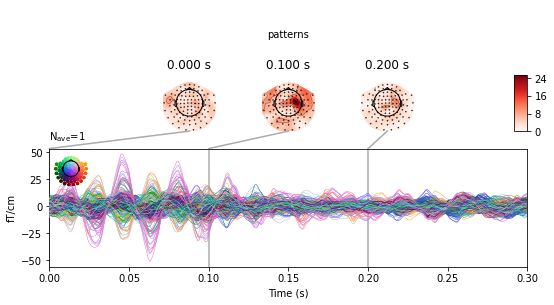

    Reading a source space...
    Computing patch statistics...
    Patch information added...


/home/user/PycharmProjects/FingerMovementDecoder/utils/storage_management.py:79: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Generated/src414578ae25732b53f1a49781cb4d45e0.fif) does not conform to MNE naming conventions. All source space files should end with -src.fif, -src.fif.gz, _src.fif, _src.fif.gz, -fwd.fif, -fwd.fif.gz, _fwd.fif, _fwd.fif.gz, -inv.fif, -inv.fif.gz, _inv.fif or _inv.fif.gz
  return reader(os.path.join(address, file))


    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
Loading surfaces...

Loading the solution matrix...

Three-layer model surfaces loaded.
Loaded linear_collocation BEM solution from /home/user/PycharmProjects/FingerMovementDecoder/Source/Subjects/Az_Mar_05/Generated/bemc8a3c9137937be158945fda3cc65bdce.fif
Reading forward solution from ../Source/Subjects/Az_Mar_05/Generated/fwd4d260adaf615b561046dbbda3981a9c9.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...


/home/user/PycharmProjects/FingerMovementDecoder/utils/storage_management.py:79: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Generated/fwd4d260adaf615b561046dbbda3981a9c9.fif) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  return reader(os.path.join(address, file))


    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 204 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    204 x 204 full covariance (kind = 1) found.
Reading inverse operator decomposition from ../Source/Subjects/Az_Mar_05/Generated/inve72979bfaf597758fbc69155b8d56803.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    204 x 204 full covariance (kind = 1) found.
    Noise covariance matrix read.
    7498 x 7498 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    Did not find the desired covariance matrix (kind = 6)
    7498 x 7498 diagonal covariance (kind = 5) found.
    Depth priors read.
   

/home/user/PycharmProjects/FingerMovementDecoder/utils/storage_management.py:79: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Generated/cov11826792a2aeab95043091496e444ee5.fif) does not conform to MNE naming conventions. All covariance files should end with -cov.fif, -cov.fif.gz, _cov.fif or _cov.fif.gz
  return reader(os.path.join(address, file))
/home/user/PycharmProjects/FingerMovementDecoder/utils/storage_management.py:79: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Generated/inve72979bfaf597758fbc69155b8d56803.fif) does not conform to MNE naming conventions. All inverse operator files should end with -inv.fif, -inv.fif.gz, _inv.fif or _inv.fif.gz
  return reader(os.path.join(address, file))


    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Source spaces transformed to the inverse solution coordinate frame


In [106]:
evoked_time_gen = pickle.load(open(os.path.join(subject_path, 'Generated', 'evoked_time_gen.pkl'), 'rb'))

joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked_time_gen.plot_joint(times=np.arange(tmin_, tmax_, .100), title='patterns',
                           **joint_kwargs)

src = generate_src(subject, subjects_dir=subjects_dir)
conductivity = (0.3, 0.006, 0.3)
bem = generate_bem(subject, subjects_dir, conductivity)

fwd = generate_forward(
    resp_lock_lm_B1_epochs.info,
    trans='fsaverage',
    src=src, bem=bem,
    meg=True, eeg=False,
    mindist=5.0,
    n_jobs=1,
    verbose=True
)

cov = combine_covariance(
    resp_lock_lm_B1_epochs,
    resp_lock_li_B1_epochs,
    resp_lock_rm_B1_epochs,
    resp_lock_ri_B1_epochs,
)


inv = compute_inverse(evoked_time_gen.info, fwd, cov, loose=0.)
stc = compute_stc(evoked_time_gen, inv, 1. / 9., 'dSPM')

In [107]:
print('ok')

ok


In [121]:
from matplotlib.patches import Rectangle
import matplotlib
from matplotlib.figure import Figure
import pyvista
import mayavi
from mayavi.core.api import Scene
# import sobol_seq
import sobol_seq


# surfer_kwargs = dict(
#     hemi='lh', subjects_dir=subjects_dir,
#     clim=dict(kind='value', lims=[8, 12, 15]), views='lateral',
#     initial_time=.25, time_unit='s', size=(800, 800),
#     smoothing_steps=5)
brain = stc.plot(hemi='split', background='w', views=('lat', 'med'), initial_time=.05,
                 subjects_dir=subjects_dir)

Using control points [0.29364043 0.3274557  0.57330352]
